In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/htc/htc_swin-large_fpn_2x_coco_custom.py')

root='/opt/ml/detection/dataset/'

epoch = 'latest' # pth 이름

# # dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize
cfg.data.test.test_mode = True

# cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = '/opt/ml/detection/baseline/mmdetection/work_dirs/htc_swin-large_fpn_2x_coco_custom' # 확인!!!

# cfg.model.roi_head.bbox_head.num_classes = 10

# cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

dataset

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!



CocoDataset Test dataset with number of images 4871, and instance counts: 
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| category          | count | category      | count | category        | count | category    | count | category     | count |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| 0 [General trash] | 0     | 1 [Paper]     | 0     | 2 [Paper pack]  | 0     | 3 [Metal]   | 0     | 4 [Glass]    | 0     |
| 5 [Plastic]       | 0     | 6 [Styrofoam] | 0     | 7 [Plastic bag] | 0     | 8 [Battery] | 0     | 9 [Clothing] | 0     |
|                   |       |               |       |                 |       |             |       |              |       |
| -1 background     | 4871  |               |       |                 |       |             |       |              |       |
+-------------------+-------+---------------+----

In [4]:
# checkpoint path
# checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')
checkpoint_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/htc_swin-large_fpn_2x_coco_custom/latest.pth'

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model .cuda(), device_ids=[0])
# checkpoint

load checkpoint from local path: /opt/ml/detection/baseline/mmdetection/work_dirs/htc_swin-large_fpn_2x_coco_custom/latest.pth


In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.01) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 4.1 task/s, elapsed: 1193s, ETA:     0s

In [ ]:
# checkpoint

In [6]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'fold0_htc_swin_large_2x_mixup_submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


PredictionString       image_id
0  0 0.1656855 371.82266 619.57733 391.86142 641....  test/0000.jpg
1  0 0.61511153 627.89014 648.6007 692.7284 881.5...  test/0001.jpg
2  0 0.99104804 877.14886 456.27115 1023.5214 644...  test/0002.jpg
3  0 0.22749083 260.41602 735.61884 388.0984 827....  test/0003.jpg
4  0 0.712605 424.10916 502.6541 507.29373 577.77...  test/0004.jpg

### Visualization

In [7]:
import os
import random
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from pycocotools.coco import COCO

test_json = COCO('/opt/ml/detection/dataset/test.json') # test.jon 경로
cate_info = test_json.dataset['categories']

# 카테고리 별 색깔 설정
cate_color = {0: 'red', 1:'orange', 2:'yellow', 3:'green', 4:'blue', 5:'pink', 6:'brown', 7:'purple', 8:'navy', 9:'white'}
# 카테고리 별 이름
cate_name = []
for j in range(10):
    cate_name.append(cate_info[j]['name'])
# print(cate_name)

# 폰트
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 40)

submission_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/htc_swin-large_fpn_2x_coco_custom/fold0_htc_swin_large_2x_mixup_submission_latest.csv' # submission.csv 경로
submission = pd.read_csv(submission_path)
# submission['PredictionString'].info

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


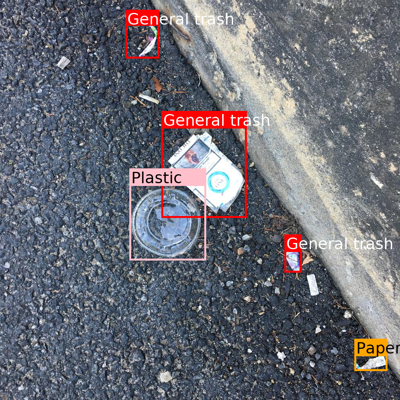

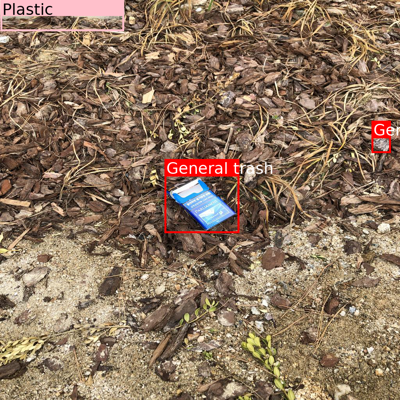

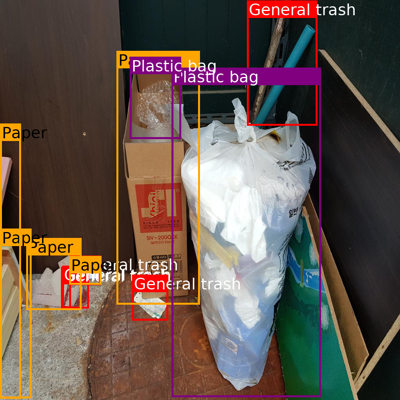

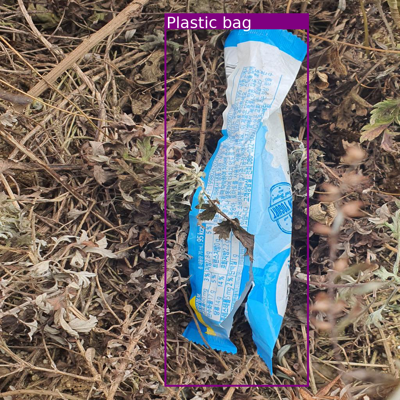

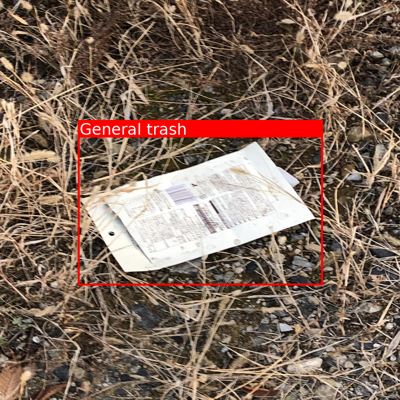

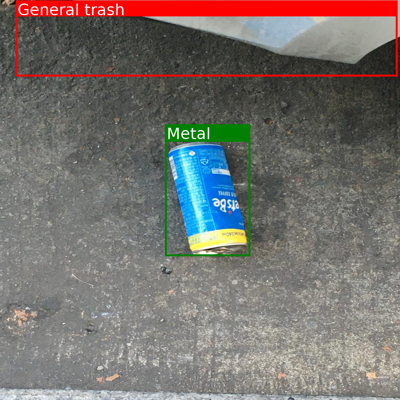

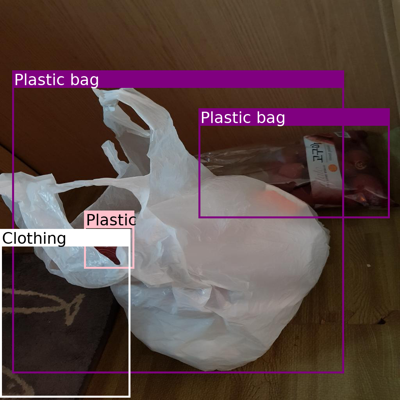

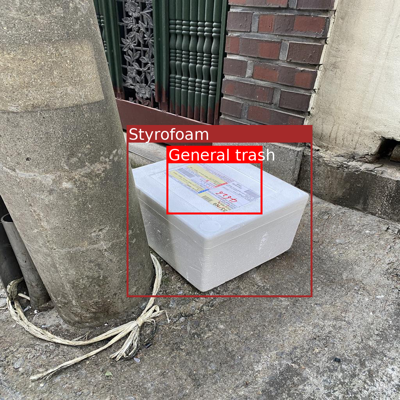

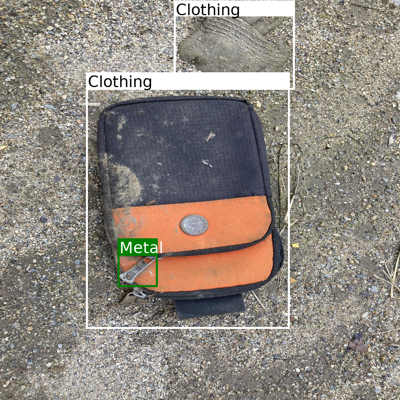

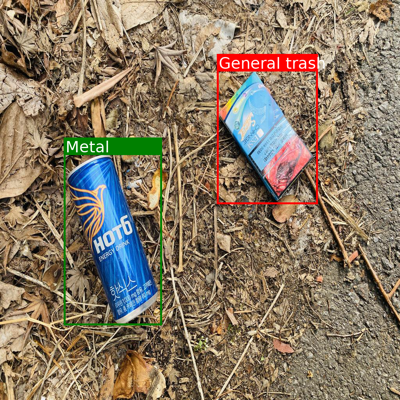

In [15]:
data_dir = '/opt/ml/detection/dataset'
for _ in range(10):
    ran_num = random.randint(0, 4870)
    test_image = submission.iloc[ran_num]['image_id']
    infos = submission.iloc[ran_num]['PredictionString']
    if type(infos) == str:
        bbox_info = infos.split()
    else:
        continue
    # print(bbox_info)

    bboxes = []
    for i, v in enumerate(bbox_info):
        if i % 6 == 0:
            bboxes.append([])
        bboxes[-1].append(float(v))

    img = Image.open(os.path.join(data_dir, test_image))
    draw = ImageDraw.Draw(img)
    # bboxes의 리스트들은 label, score, xmin, ymin, xmax, ymax 순서
    for idx in range(len(bboxes)):
        if bboxes[idx][1] > 0.5: # score 높은 것만 골라 시각화
            [xmin, ymin, xmax, ymax] = bboxes[idx][2:]
            draw.rectangle((xmin, ymin, xmax, ymax), outline=cate_color[int(bboxes[idx][0])], width = 5)
            # text box는 bounding box 위에 그리기
            # 만약 bounding box위에 text box 그릴 수 없으면 안 쪽에 그리기
            y_pos = ymin-40
            if ymin < 40:
                y_pos = ymin
            draw.rectangle((xmin, y_pos, xmax, y_pos+40), fill=cate_color[int(bboxes[idx][0])], width = 5)
            # text_color
            if int(bboxes[idx][0]) in [1, 2, 5, 9]:
                text_color = 'black'
            else:
                text_color = 'white'
            # text 위치
            text_pos = (xmin+5, y_pos)
            draw.text(text_pos, cate_name[int(bboxes[idx][0])], fill=text_color, font=font)

    img_small = img.resize((400, 400))
    img_small.show()